In [1]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks
import importlib as imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Pseudoarclength continuation

128 931 6 0 174
1	3	
1	3	1	3	
1603	930	
128 125
4.09066e+01	7.59375e-02	6.48266e-01	1.13455e-01	440	1	1.92163e-13	
Subcritical Hopf bifurcation!	40.906607
4.22934e+01	1.50000e-02	-1.98280e-01	5.36687e-02	457	1	7.06752e-14	
Saddle-node bifurcation!	42.293425
4.20029e+01	6.66667e-03	2.14444e-01	-2.97149e-02	467	1	7.46221e-14		
Saddle-node bifurcation!	42.002919
4.32419e+01	3.37500e-02	6.30618e-01	3.59565e-02	510	1	1.22241e-13	
Supercritical Hopf bifurcation!	43.241895
1.00073e+02	7.59375e-02	9.88489e-01	7.68163e-02	1213	1	1.00094e-13	
 92.53290870800265


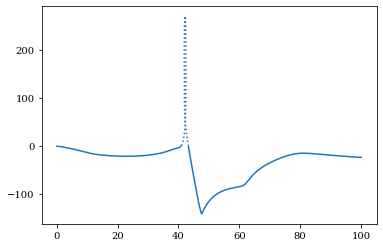

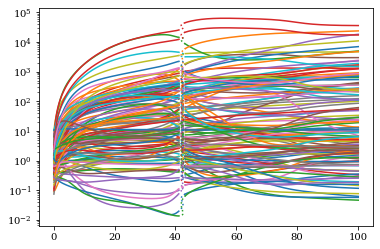

In [2]:
imp.reload(rmtchem)
n=128
nr=int(1.5*n*np.log(n))
nd=int(0.05*n)
na=int(0*nr)
seed=875 #nice snaking
seed=174
natoms=3

print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_array(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=10e-2, output=2,stop=False,sn_detect=False,hopf_detect=True,cond_detect=False)

stop=timeit.default_timer()
print('\n',stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [4]:
epsilon

40.916606828575944

In [ ]:
imp.reload(rmtchem)
import os
import warnings
warnings.simplefilter("ignore")

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon0=41
m0=np.argmin(np.abs(epsilons-epsilon0))
np.random.seed(2)
# X0=Xs[m0]
X0=Xs[m0]*2*np.random.random(size=n)
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-2
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilons[m0],np.max(np.real(evals[m0])))

start=timeit.default_timer()
ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25)
stop=timeit.default_timer()
print(stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/Xs[m0])
plt.show()
plt.yscale('log')
plt.plot(ts[:-1]/tscale,np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()

mind=np.argmin(np.linalg.norm((Xs-Xts[:,-1])/Xts[:,-1],axis=1))
print(np.linalg.norm((Xs-Xts[:,-1])/Xts[:,-1],axis=1)[mind],epsilons[mind])

41.02244702724556 2.100116074811656


2.50441e+01	-2.25000e-04	-3.02838e-01	-8.91717e-04	913	1	6.13185e-12	
Saddle-node bifurcation!	25.044068
9.54258e+01	-4.37894e-02	5.24552e-02	1.01102e-01	1785	1	5.78574e-14		
Saddle-node bifurcation!	95.425807


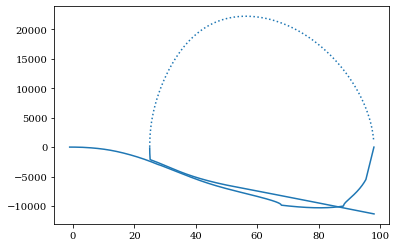

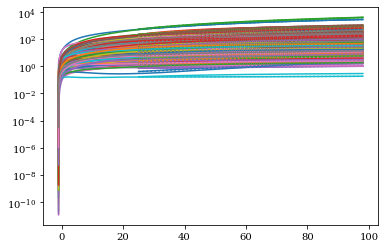

In [4]:
imp.reload(rmtchem)
Xs2,epsilons2,evals2,bif2,dxs2=rmtchem.pseudoarclength_log(Xts[:,-1], eta, nu, k, XD1, XD2, epsilon, 101, ds=-1e-4, dsmax=1e-1,output=2,stop=False,sn_detect=False,hopf_detect=False)
plt.figure()
inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons2[inds],np.max(np.real(evals2),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons2[inds],np.max(np.real(evals2),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [1]:
np.save('data/sn/Xs.npy',Xs)
np.save('data/sn/epsilons.npy',epsilons)
np.save('data/sn/evals.npy',evals)
np.save('data/sn/ts.npy',ts)
np.save('data/sn/Xts.npy',Xts)

NameError: name 'np' is not defined

### sweep of seeds

128 310 12 155 185
128 125

 58.955642418935895


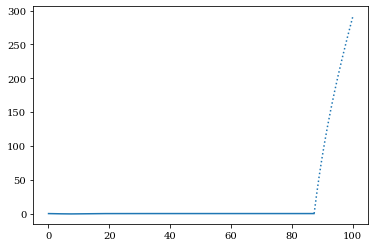

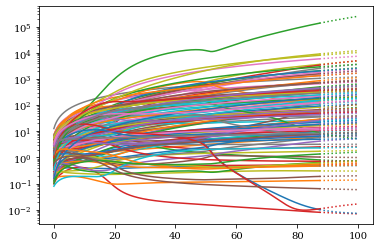

128 310 12 155 715
124 121

 77.02609614096582


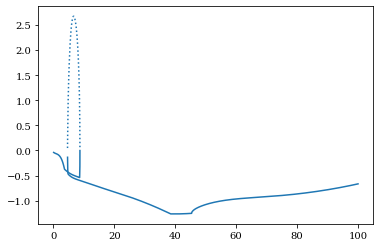

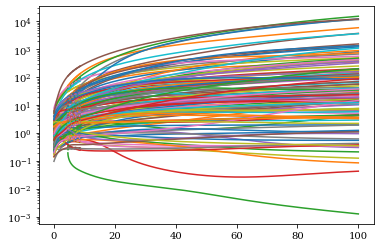

128 310 12 155 656
127 124

 74.8627700433135


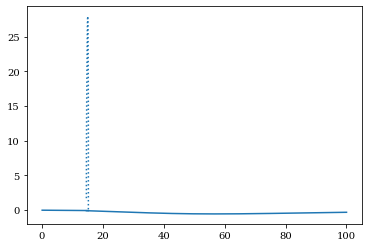

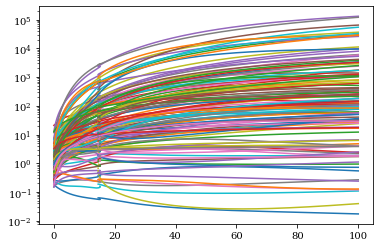

128 310 12 155 524
127 124

 78.82230691285804


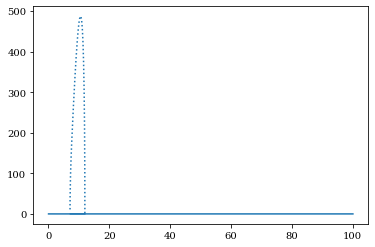

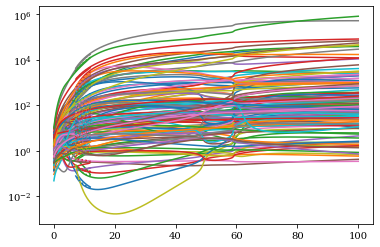

128 310 12 155 899
127 124

Failed to converge!	75.729167	0.022916	0.000000

 156.21365034207702


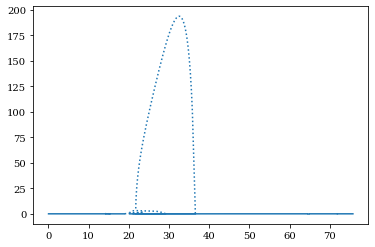

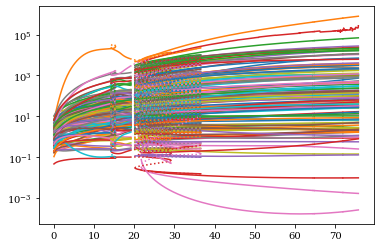

128 310 12 155 247
127 124

 149.734374595806


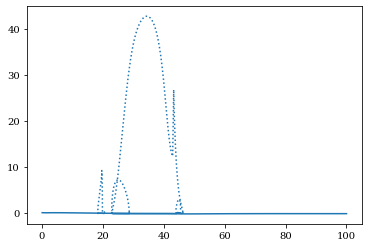

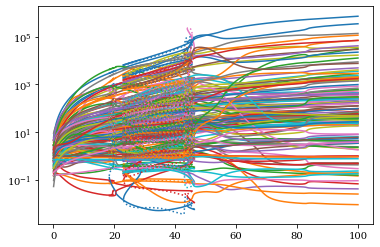

128 310 12 155 535
128 125

 65.21239059697837


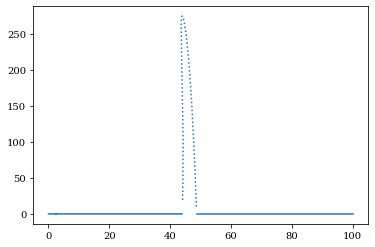

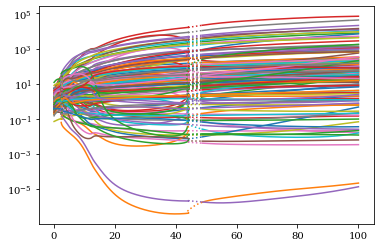

128 310 12 155 602
128 125

Failed to converge!	-0.996876	0.000000	0.033750

 23.2091973409988


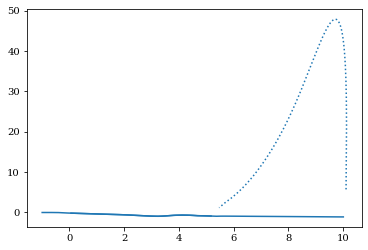

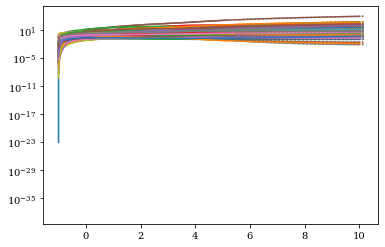

128 310 12 155 976
128 125

 92.29000389995053


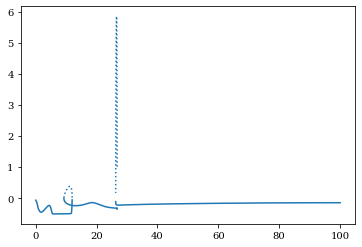

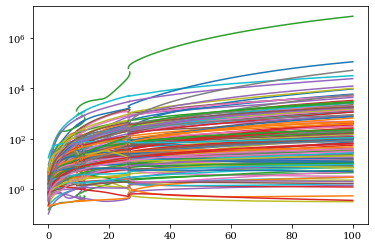

128 310 12 155 477
126 123

 65.00384796690196


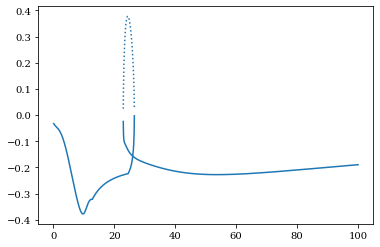

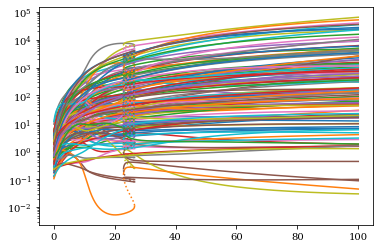

128 310 12 155 295
128 125

 83.38588701188564


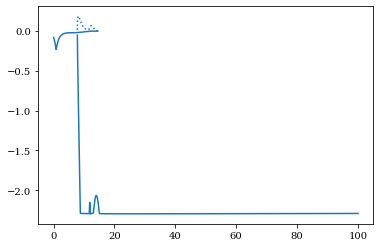

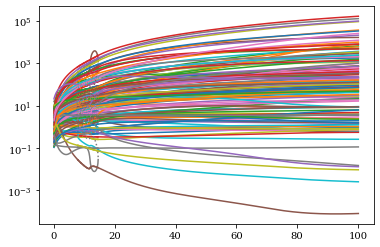

128 310 12 155 838
126 123

 80.95044781919569


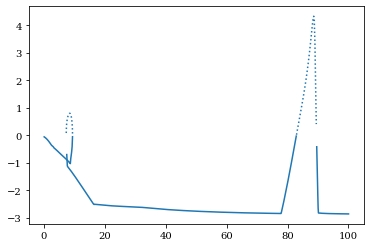

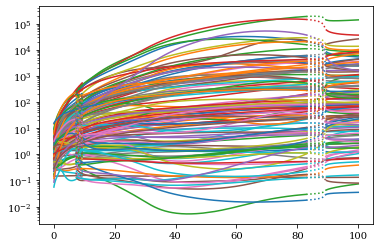

128 310 12 155 80
126 123

 98.2818803768605


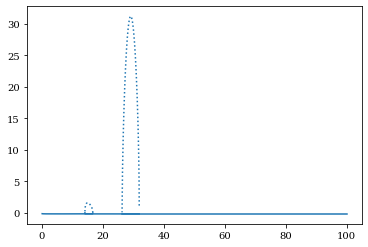

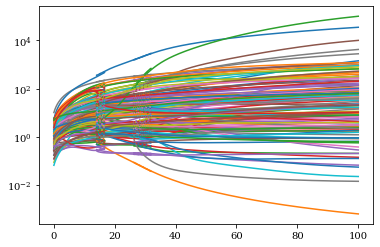

128 310 12 155 829
124 121

 71.77083946811035


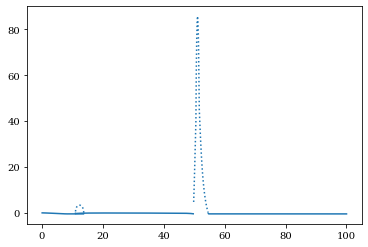

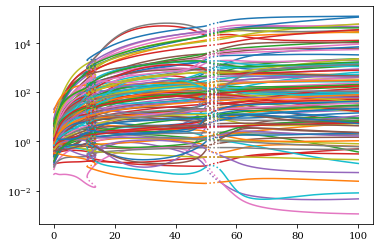

128 310 12 155 562
128 125

Failed to converge!	18.897884	-0.320463	0.000000

 18.329400654882193


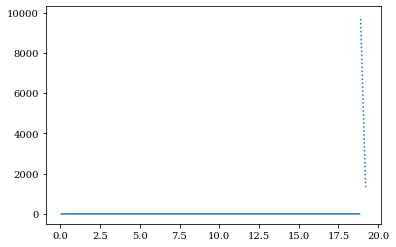

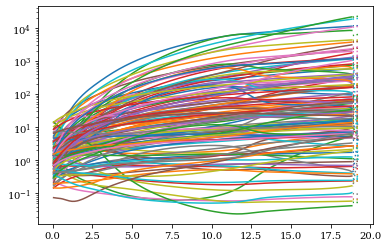

128 310 12 155 430
127 124

 81.8508487008512


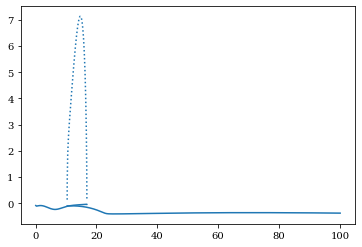

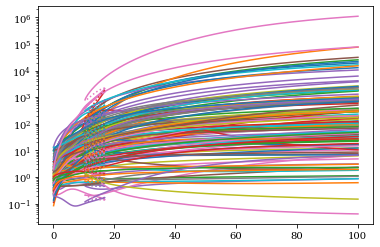

128 310 12 155 351
128 125

 69.61095571005717


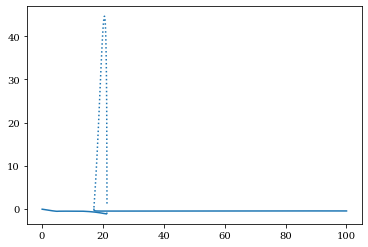

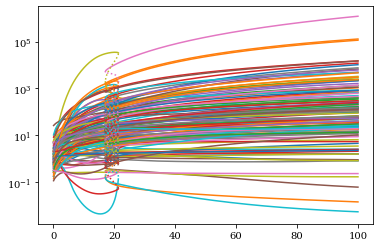

128 310 12 155 725
128 125

 80.84408418787643


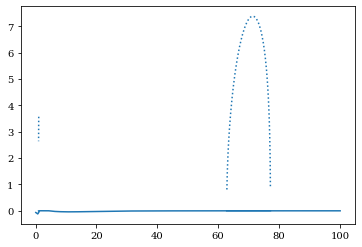

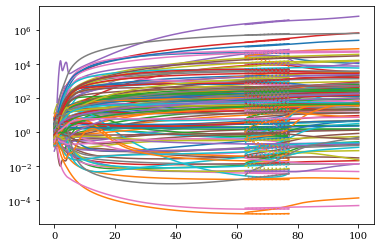

128 310 12 155 60
128 125

 93.89592369506136


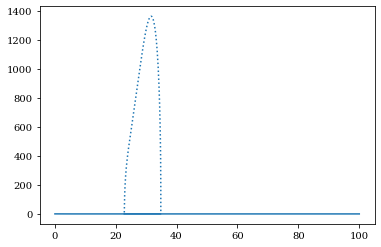

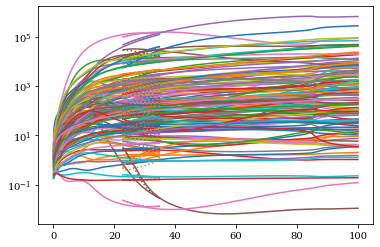

128 310 12 155 994
127 124

 81.28224225295708


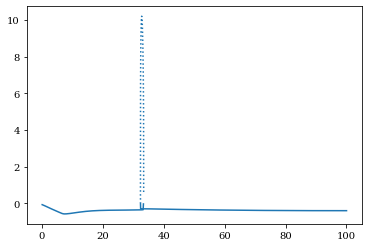

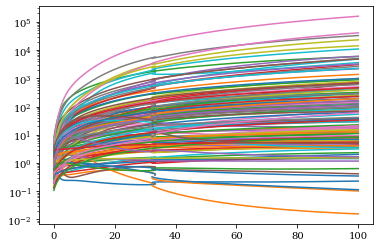

128 310 12 155 914
127 124

 56.20233596721664


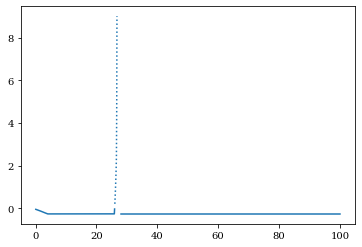

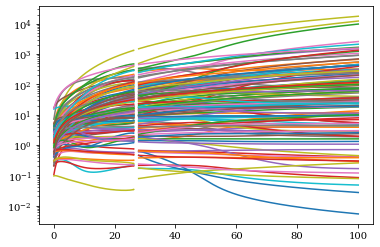

128 310 12 155 682
127 124

 73.37519154977053


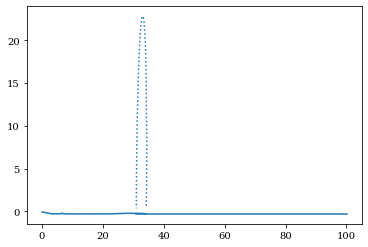

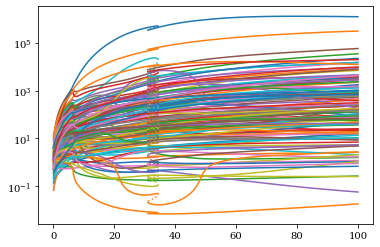

128 310 12 155 704
128 125

 79.38862628489733


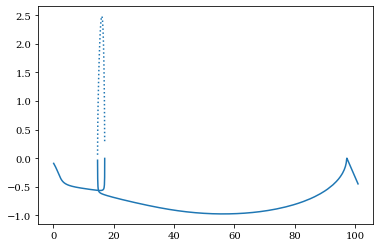

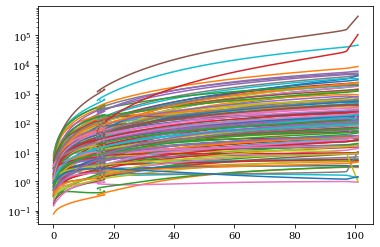

128 310 12 155 1022
128 125

 84.95802049897611


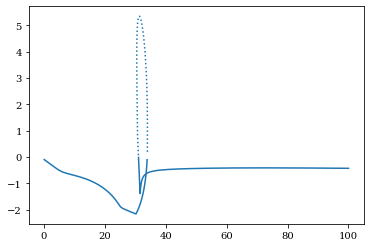

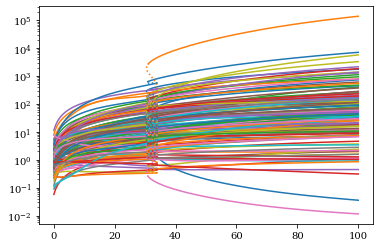

128 310 12 155 251
127 124

 78.98092450061813


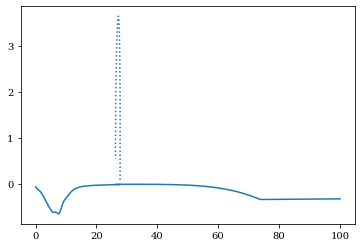

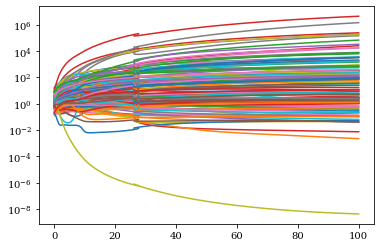

128 310 12 155 779
124 121

 202.6715454738587


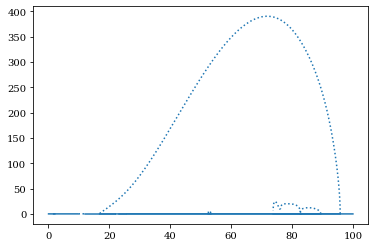

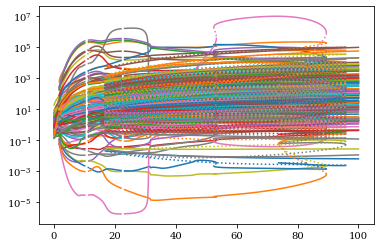

128 310 12 155 667
125 122

 73.72437462676316


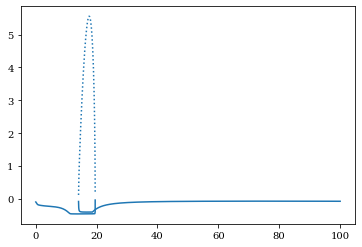

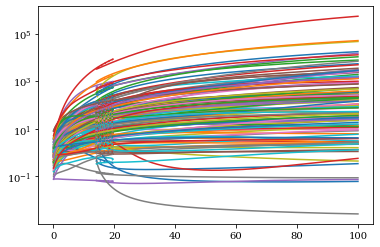

128 310 12 155 478
128 125

 62.03621023893356


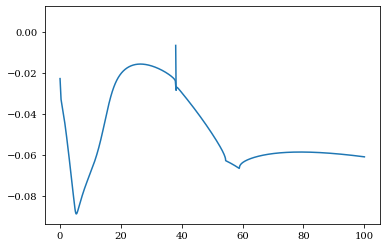

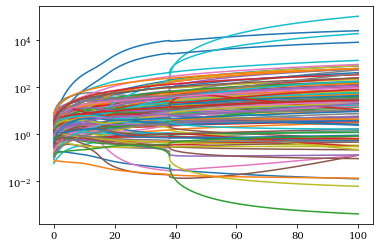

128 310 12 155 560
127 124

 94.45312720816582


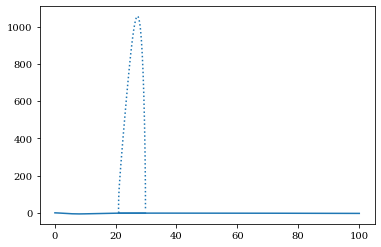

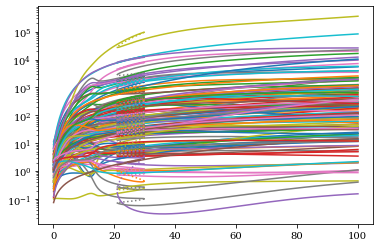

128 310 12 155 508
126 123

 123.39452924625948


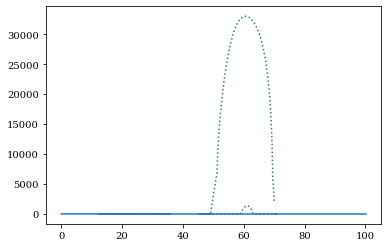

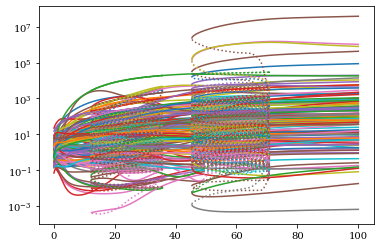

128 310 12 155 94
127 124

 85.95229292521253


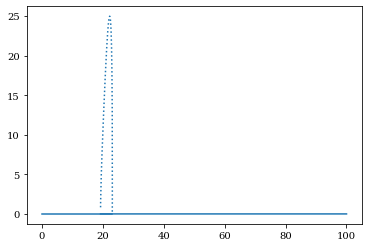

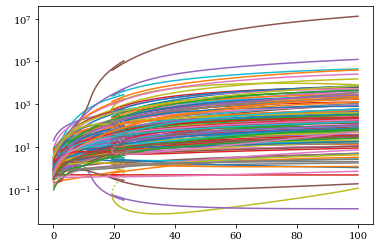

128 310 12 155 768
127 124

 74.62223261082545


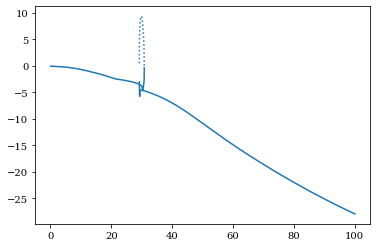

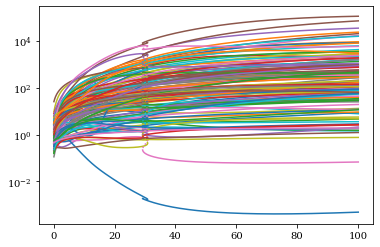

128 310 12 155 618
128 125

 96.79562921496108


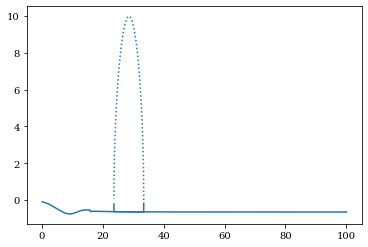

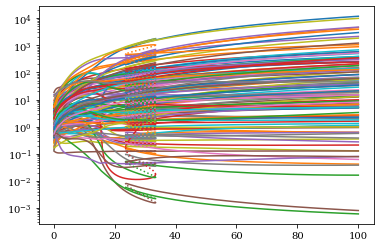

128 310 12 155 791
128 125

 71.8790873051621


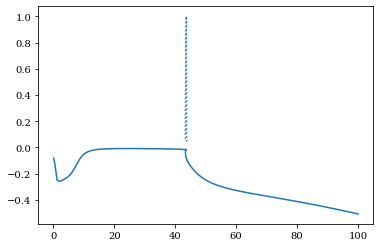

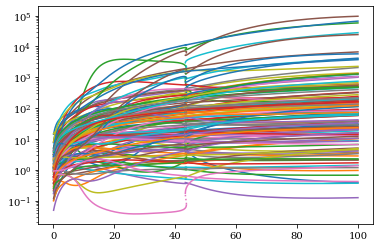

128 310 12 155 805
123 120

Failed to converge!	30.263378	-0.000001	0.000010

 63.54457560228184


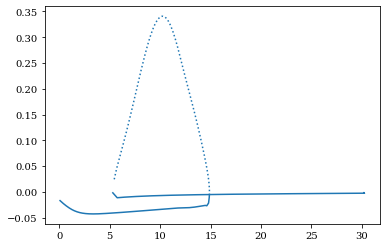

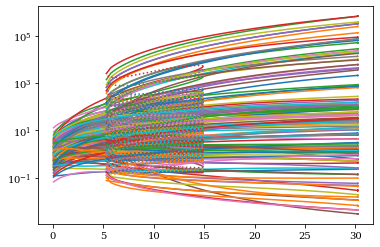

128 310 12 155 104
127 124

 83.29704304691404


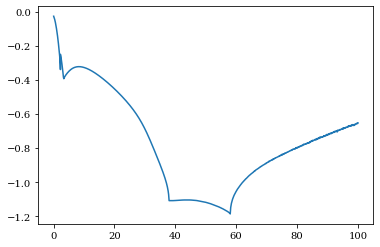

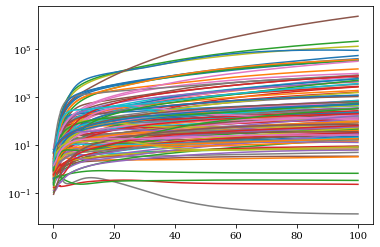

128 310 12 155 142
127 124

 225.65782498801127


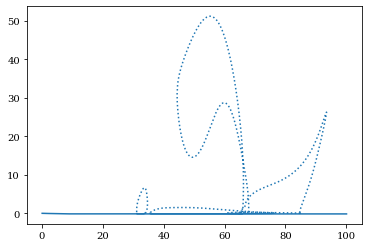

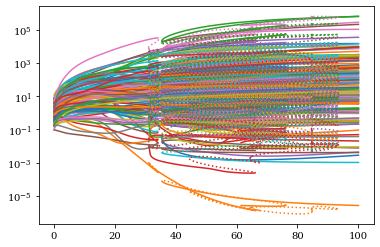

128 310 12 155 650
128 125

 79.34023483842611


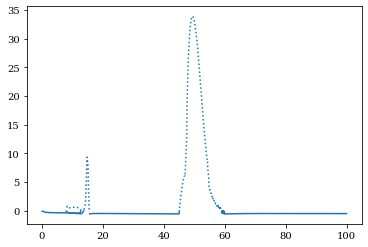

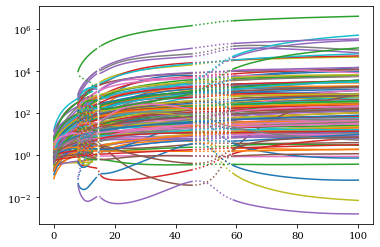

128 310 12 155 294
127 124

 88.43072506599128


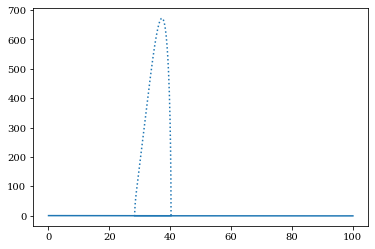

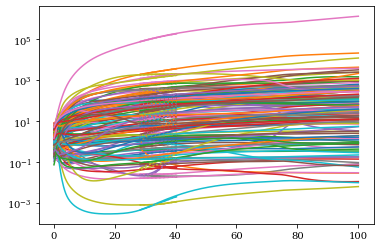

128 310 12 155 882
128 125

 71.11753499880433


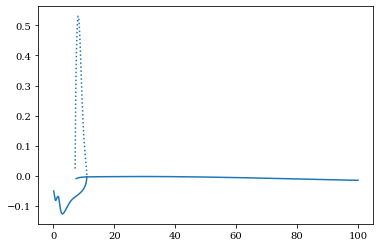

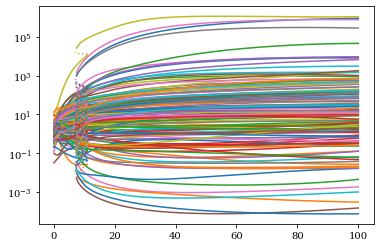

128 310 12 155 594
126 123

 98.76211712276563


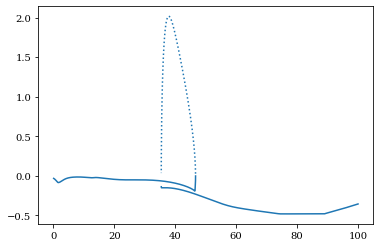

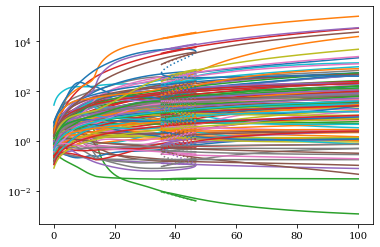

128 310 12 155 619
127 124

 73.09277040231973


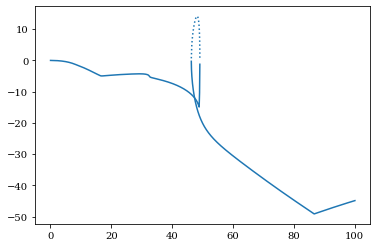

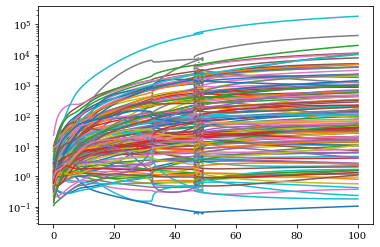

128 310 12 155 163
128 125

 82.62256924668327


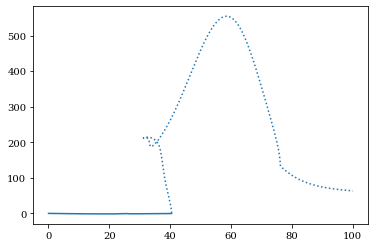

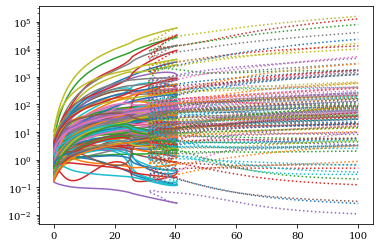

128 310 12 155 161
127 124

 92.82119428925216


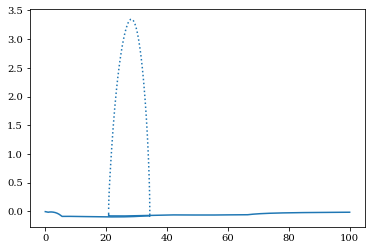

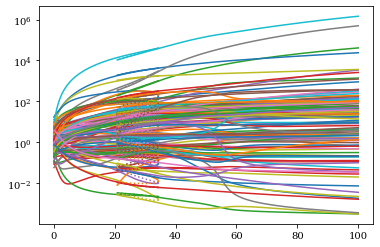

128 310 12 155 820
126 123

 61.24932676739991


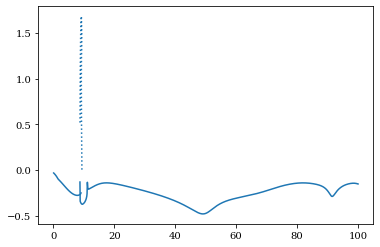

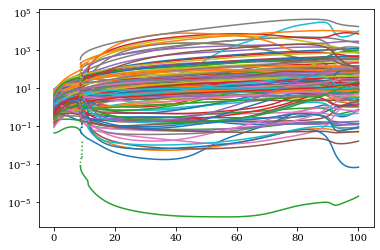

128 310 12 155 644
128 125

 99.80486970301718


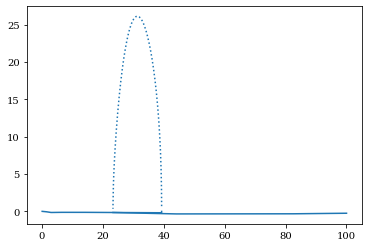

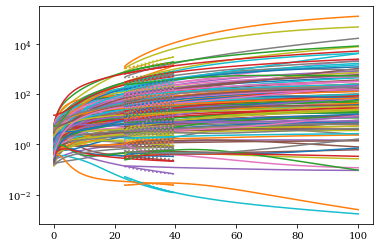

128 310 12 155 880
126 123

 75.05927010206506


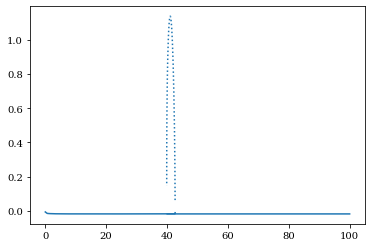

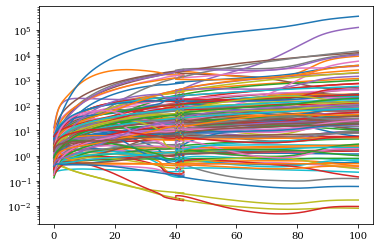

128 310 12 155 968
128 125

 76.05499129090458


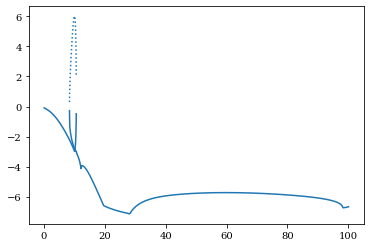

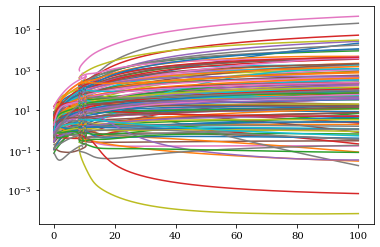

128 310 12 155 629
127 124

 94.6399279772304


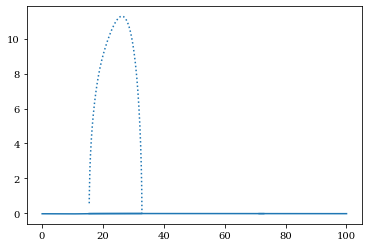

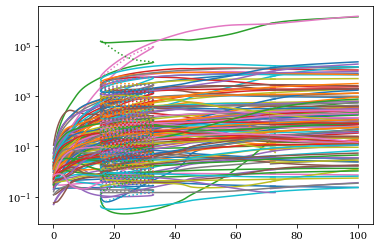

128 310 12 155 781
128 125


In [ ]:
f=open('seeds','r')
seeds=np.array(f.readlines(),dtype=int)
f.close()

for seed in seeds:
    imp.reload(rmtchem)
    n=128
    nr=int(0.5*n*np.log(n))
    nd=int(0.1*n)
    na=int(0.5*nr)
    natoms=3
    print(n,nr,nd,na,seed)

    np.random.seed(seed)
    eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,False) 
    row,col=np.where(eta[::2]-nu[::2]!=0)
    data=(eta[::2]-nu[::2])[row,col]
    A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
    adj=A.T.dot(A)
    g=nx.convert_matrix.from_scipy_sparse_array(adj)
    lcc=np.array(list(max(nx.connected_components(g), key=len)))
    n=len(lcc)
    eta=eta[:,lcc]
    nu=nu[:,lcc]
    G=G[lcc]
    d0=1e6
    d1min=0
    d1max=100
    XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
    m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
    print(len(lcc),np.linalg.matrix_rank(m))
    
    X0=np.exp(-G)
    start=timeit.default_timer()
    Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=1e-1, output=0,stop=False,sn_detect=False,hopf_detect=False,cond_detect=False)


    stop=timeit.default_timer()
    print('\n',stop-start)
    plt.figure()
    inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
    inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

    for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
    for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
    plt.show()

    plt.figure()
    inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
    inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
    plt.yscale('log')
    for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        for i in range(n):
            plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
    for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        for i in range(n):
            plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
    plt.show()

### Hopf bifurcations

64 133 6 33 25
1	3	
1	3	1	3	
274	132	
64 61
2.91300e+01	9.85261e-02	9.15188e-01	9.01180e-02	716	1	2.42882e-09	
Subcritical Hopf bifurcation!	29.130034
5.41773e+01	9.85261e-02	9.60451e-01	9.46240e-02	984	1	3.40579e-10	
Subcritical Hopf bifurcation!	54.177330
7.95420e+01	9.85261e-02	9.90606e-01	9.75950e-02	1247	1	1.20755e-10	
Supercritical Hopf bifurcation!	79.542026


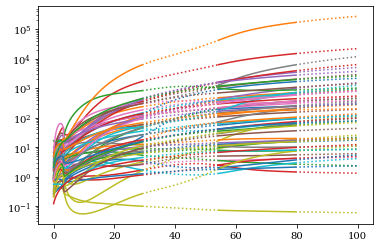

In [43]:
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.25*nr)
seed=25
natoms=3
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-4, dsmax=1e-1,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

29.140034279109578 577.3724515105785 0.3003452263480314
0.000136	0.000003	53024	245	lsoda	
Found oscillating state!
True 81.33590200007893


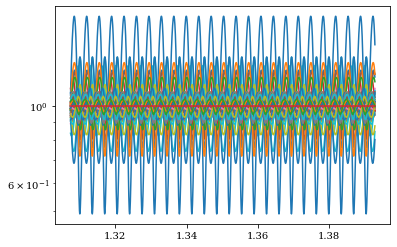

51050 54374


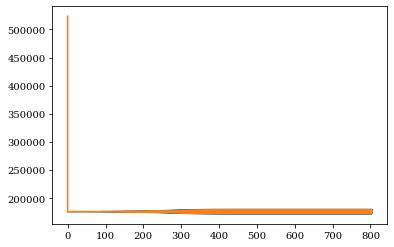

175837.34943759174 176131.9191662977 175837.3494376272 176130.39745503847 0.779534000941305 166.15386684715085


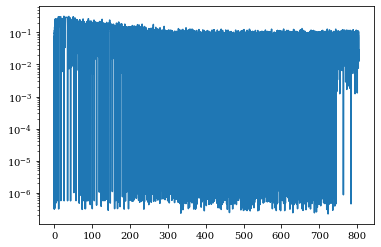

1


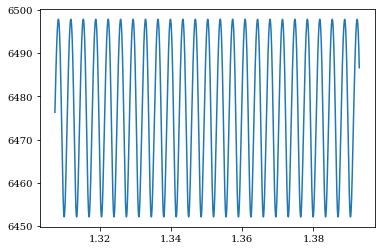

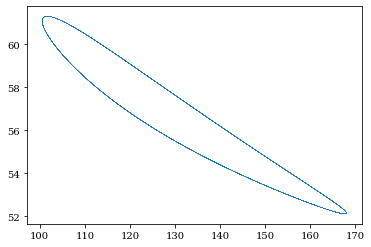

In [44]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-2
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=200)
m0=int(m0+9*(len(ts)-m0)/10)

stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts[m0:]/tscale,np.transpose(Xts)[m0:]/X0)
plt.show()

sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
print(m0,len(ts))
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
dn1=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm((Xts[:,i]-X0)/X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
dn2=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm(Xts[:,i]-X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2, dn1,dn2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


In [45]:
np.save('data/hopf/Xs.npy',Xs)
np.save('data/hopf/epsilons.npy',epsilons)
np.save('data/hopf/evals.npy',evals)
np.save('data/hopf/ts.npy',ts)
np.save('data/hopf/Xts.npy',Xts)

### Chemical chaos 

64 133 6 66 402
1	3	
1	3	1	3	
9554	132	
5.59512e+01	9.85261e-02	9.80982e-01	1.00374e-01	644	1	4.92730e-14	
Supercritical Hopf bifurcation!	55.951172


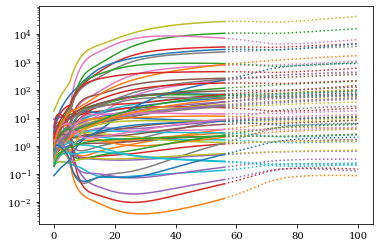

In [46]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
natoms=5
seed=402
natoms=5
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, d1min,d1max,ds=1e-4, dsmax=1e-1,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

90.95384375070171 1.4903952591297285
0.000214	0.000002	49134	24	lsoda	Unexpected istate in LSODA.
Found oscillating state!
94.09869565884583


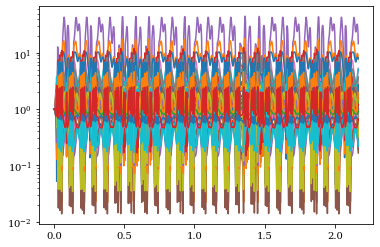

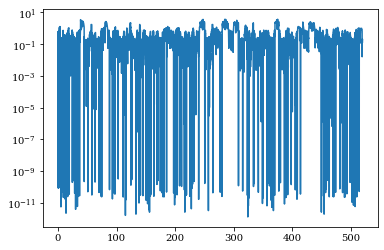

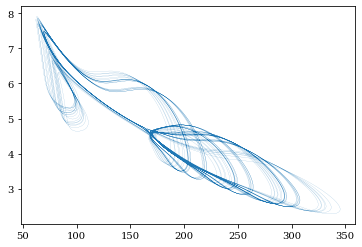

In [47]:
imp.reload(rmtchem)
import os
import warnings
warnings.simplefilter("ignore")

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon0=91
m0=np.argmin(np.abs(epsilons-epsilon0))
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-1
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilons[m0],np.max(np.real(evals[m0])))

start=timeit.default_timer()
ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25)
stop=timeit.default_timer()
print(stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()


20 57.85404924427026 0.00012097183746864293


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


/Users/zack/Documents/rmtchem/rmtchem.py:131: RuntimeWarning: divide by zero encountered in true_divide
  dt=np.min([np.mean(10/tscales[tinds[:-1]]),100*dt0,ts[-1]/2,dtmax])


0.014190	0.000209	5850	99	irk  	Unexpected istate in LSODA.
Found oscillating state!
True 7.0127434910000375


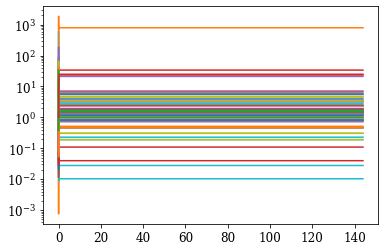

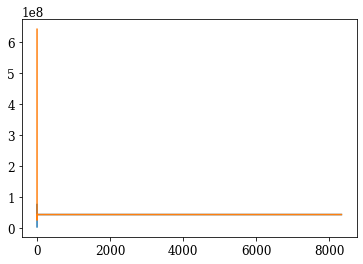

2678823.1087422688 42635553.72898769 634193247.0682617 42635553.72896941


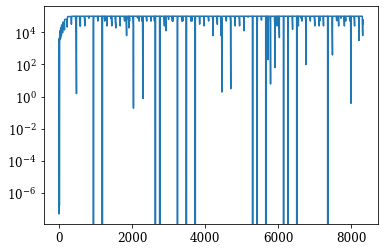

1


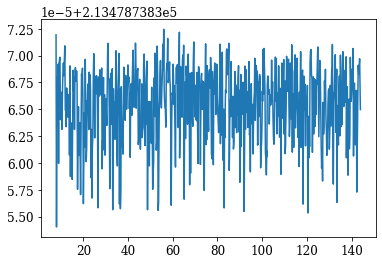

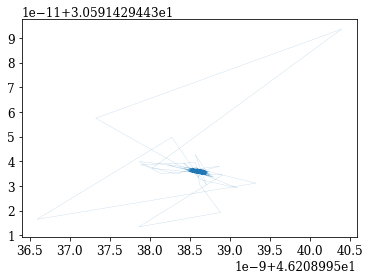

In [42]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=20
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)

stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilon-1e-1)*XD1, XD2)
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


0.713588	0.286412	4941	11	irk  	Unexpected istate in LSODA.
Failed to find state before maxtime 578.5404924427025


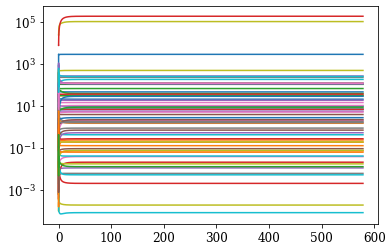

/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


0.350831	0.175415	471876	0	irk  	Unexpected istate in LSODA.
Found steady state!
5.262462870665838 True


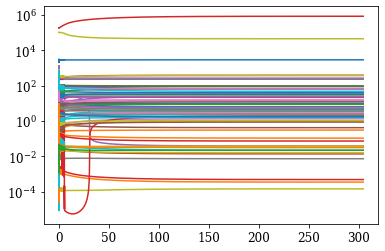

In [43]:
imp.reload(rmtchem)
np.random.seed(1)
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,10*dt,output=True,cont=True)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()
ts,Xts,success,m0,state=rmtchem.integrate(Xts[:,-1]*(1+1e-2*(0.5-np.random.random(size=len(X0)))),eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,dt,output=True,cont=False,maxsteps=1e7)
print(ts[-1]/tscale,success)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()

In [44]:
success,solx=rmtchem.steady(Xts[:,-1],eta,nu,k,(1+epsilon)*XD1,XD2)
print(success,np.linalg.norm((solx-Xts[:,-1])/solx))
ev,evecs=np.linalg.eig(rmtchem.jac(0,solx,eta,nu,k,(1+epsilon)*XD1,XD2))
print(ev[np.argmax(np.real(ev))])

True 0.0
(-0.022855819914751975+0j)


0.365176	1.000000e-02	1808	
Subcritical Hopf bifurcation!		36.517578
0.366579	4.882813e-06	1951	
Saddle-node bifurcation!	36.657866	4.882813e-06	1	1	0.000657	4.306462	4	4	3	
0.061400	-1.000000e-02	1387	
Subcritical Hopf bifurcation!		6.140000
0.061388	-6.103516e-07	1406	
Saddle-node bifurcation!	6.138784	-6.103516e-07	1	1	0.000000	45.493017	2	2	1	
0.366579	4.882813e-06	4866	
Saddle-node bifurcation!	36.657883	4.882813e-06	1	1	0.000554	3.864281	3	3	4	
0.365130	-2.500000e-03	4997	
Subcritical Hopf bifurcation!		36.512966


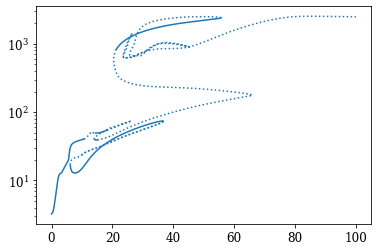

In [45]:
imp.reload(rmtchem)
X2s,epsilon2s,eval2s,bif2=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,1e-2,output=2,stepsmax=5000,stop=False)
X3s,epsilon3s,eval3s,bif3=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,-1e-2,output=2,stepsmax=5000,stop=False)


plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval2s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval2s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval3s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval3s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [46]:
np.save('data/chaos/Xs1.npy',Xs)
np.save('data/chaos/epsilons1.npy',epsilons)
np.save('data/chaos/evals1.npy',evals)
np.save('data/chaos/Xs2.npy',X2s)
np.save('data/chaos/epsilons2.npy',epsilon2s)
np.save('data/chaos/evals2.npy',eval2s)
np.save('data/chaos/Xs3.npy',X3s)
np.save('data/chaos/epsilons3.npy',epsilon3s)
np.save('data/chaos/evals3.npy',eval3s)

60 57.85404924427026 2.2959410919206036e-05


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


/Users/zack/Documents/rmtchem/rmtchem.py:131: RuntimeWarning: divide by zero encountered in true_divide
  dt=np.min([np.mean(10/tscales[tinds[:-1]]),100*dt0,ts[-1]/2,dtmax])


0.908137	0.063144	512069	149	lsoda	expected istate in LSODA.A.
Found oscillating state!
0.971281	0.062662	524904	197	lsoda	
Failed to find state before maxtime 2
True 663.6959975749996


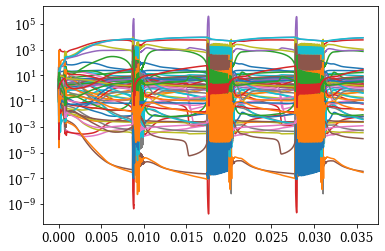

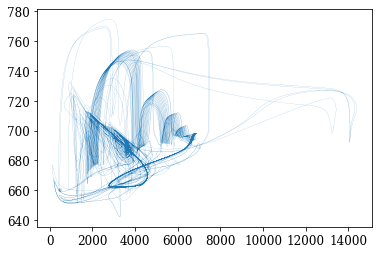

In [92]:
imp.reload(rmtchem)

Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=60
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))

dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()

ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2, 2,dt,output=True,cont=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()

ind1=0
ind2=7
tmax=ts[-1]
tinds=np.where(ts>tmax/2)[0]
plt.plot(Xts[ind1,tinds],Xts[ind2,tinds],zorder=-1,linewidth=0.1,alpha=1.0)
plt.show()


In [117]:
np.save('data/chaos/ts.npy',ts[tinds[::2]])
np.save('data/chaos/Xts.npy',np.array([Xts[ind1,tinds[::2]],Xts[ind2,tinds[::2]]]))

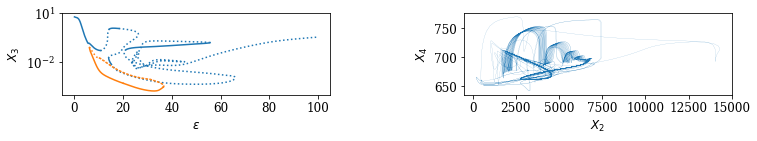

In [118]:
Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')
Xs2=np.load('data/chaos/Xs2.npy')
epsilons2=np.load('data/chaos/epsilons2.npy')
evals2=np.load('data/chaos/evals2.npy')
Xs3=np.load('data/chaos/Xs3.npy')
epsilons3=np.load('data/chaos/epsilons3.npy')
evals3=np.load('data/chaos/evals3.npy')
ts=np.load('data/chaos/ts.npy')
Xts=np.load('data/chaos/Xts.npy')
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
tmax=2*np.pi/(np.imag(evals[m,np.argmax(np.real(evals[m]))]))*500

lst=range(n)
lst=[3]

plt.subplots(1,2,figsize=(12,1.5))

plt.subplot(1,2,1)

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$X_3$')
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[0])

inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[1])

inds1=np.where(np.max(np.real(evals3),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals3),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],ls=':',color=colors[1])

ax=plt.subplot(1,2,2)
ax.set_rasterization_zorder(0)
plt.xlabel(r'$X_2$')
plt.ylabel(r'$X_4$')

plt.plot(Xts[0],Xts[1],zorder=-1,linewidth=0.1,alpha=1.0)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3c.pdf',dpi=300)
plt.show()

### Empirical reaction network stoichiometry

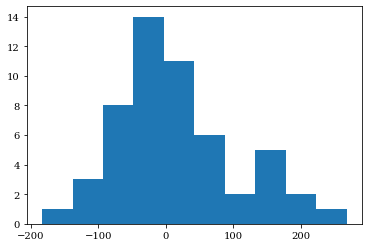

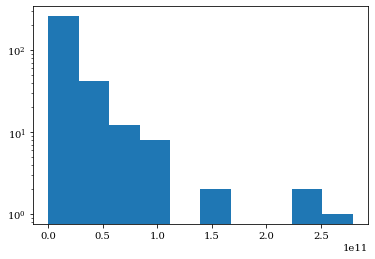

In [82]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

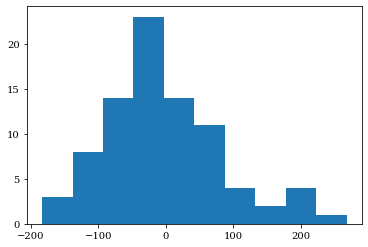

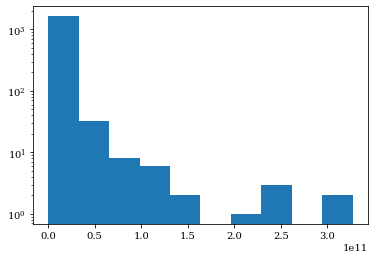

In [95]:
gas=ct.Solution('data/pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()